In [ ]:
import cv2
import torch
from torchvision.models import resnet34
from torchvision.transforms import transforms
from PIL import Image
import os
import numpy as np
import csv
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Se utilizará cuda para el modelo\n")
else:
    device = torch.device('cpu')
    print("Se utilizará cpu para el modelo\n")

model_path = r"/content/drive/MyDrive/Colab_Notebooks/res_model-hold.pth"
weights_path = r"/content/drive/MyDrive/Colab_Notebooks/res-pesos-modelo-hold.pth"
classes = ['Fondo', 'Muerdago']

# Cargar el modelo y sus pesos en CPU
ResNet34 = torch.load(model_path, map_location=torch.device('cpu'))
ResNet34.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))
ResNet34.to(device)  # Mover el modelo a la GPU si está disponible
ResNet34.eval()

transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Ruta de la imagen que deseas predecir.
image_path = r"/content/drive/MyDrive/Colab_Notebooks/DJI_0090_v10_33.png"
input_image = cv2.imread(image_path)
image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

Se utilizará cuda para el modelo



In [ ]:
def pad_with_zeros(image, pad_size):
    padded_image = np.pad(image, [(pad_size, pad_size), (pad_size, pad_size), (0, 0)], mode='constant')
    return padded_image

def generate_tiles(image, ResNet34, classes):
    neighborhood_size = 16
    pad_size = neighborhood_size // 2
    tile_count = 0
    padded_image = pad_with_zeros(image, pad_size)
    result_image = np.zeros(image.shape[:2])

    for i in range(pad_size, padded_image.shape[0] - pad_size):
        for j in range(pad_size, padded_image.shape[1] - pad_size):
            neighborhood = padded_image[i - pad_size:i + pad_size, j - pad_size:j + pad_size]
            neighborhood = neighborhood.astype('uint8')

            # Convierte el vecindario a una imagen de Pillow
            neighborhood_image = to_pil_image(neighborhood, "RGB")

            # Aplica las transformaciones y prepara el tensor
            neighborhood_tensor = transforms(neighborhood_image)
            neighborhood_tensor = neighborhood_tensor.unsqueeze(0)
            neighborhood_tensor = neighborhood_tensor.to(device)

            with torch.no_grad():
                # Pasa el vecindario a través de la red ResNet34
                activations = ResNet34(neighborhood_tensor)
                output = ResNet34(neighborhood_tensor)
                _, predicted = torch.max(output, 1)
                predicted_class = classes[predicted.item()]
                activations_classification = activations.squeeze()

                # Incrementa el contador de tiles
                tile_count += 1
                print(f"Procesando tile {tile_count}")
                print(f'Clase predicha: {predicted_class}')

                # Imprimir el valor actual en result_image antes de la asignación
                current_value = result_image[i - pad_size, j - pad_size]
                print(f"Coordenadas: ({i - pad_size}, {j - pad_size}) - Valor antes de la asignación: {current_value}")

                output_value = activations_classification[1].item()
                print(activations_classification)

                result_image[i - pad_size, j - pad_size] = output_value
                # Imprimir el valor después de la asignación
                current_value_after_assignment = result_image[i - pad_size, j - pad_size]
                print(f"Coordenadas: ({i - pad_size}, {j - pad_size}) - Valor después de la asignación: {current_value_after_assignment}")
                print("----------------------------------------------")

    print(f"Se obtuvieron {tile_count} tiles de la imagen.")
    return result_image

In [ ]:
result_image = generate_tiles(image,ResNet34,classes)

Se han truncado las últimas 5000 líneas del flujo de salida.
----------------------------------------------
Procesando tile 89168
Clase predicha: Fondo
Coordenadas: (297, 67) - Valor antes de la asignación: 0.0
tensor([1.0000e+00, 5.9982e-09], device='cuda:0')
Coordenadas: (297, 67) - Valor después de la asignación: 5.998199270607074e-09
----------------------------------------------
Procesando tile 89169
Clase predicha: Fondo
Coordenadas: (297, 68) - Valor antes de la asignación: 0.0
tensor([1.0000e+00, 5.4716e-09], device='cuda:0')
Coordenadas: (297, 68) - Valor después de la asignación: 5.471619601848943e-09
----------------------------------------------
Procesando tile 89170
Clase predicha: Fondo
Coordenadas: (297, 69) - Valor antes de la asignación: 0.0
tensor([1.0000e+00, 2.2041e-09], device='cuda:0')
Coordenadas: (297, 69) - Valor después de la asignación: 2.204052274024093e-09
----------------------------------------------
Procesando tile 89171
Clase predicha: Fondo
Coordenadas

In [ ]:
result_image.shape

(300, 300)

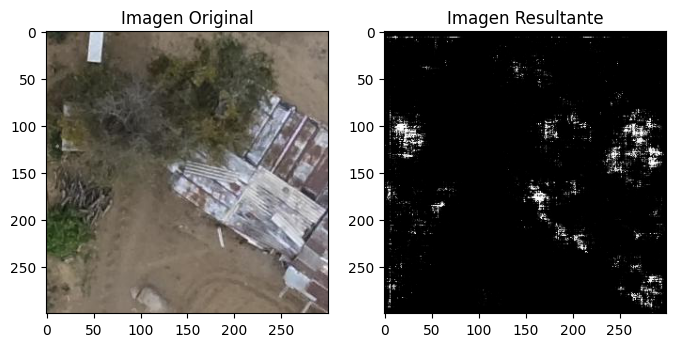

In [ ]:
# Imprimir la imagen original
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Imagen Original')

# Imprimir la imagen resultante
plt.subplot(1, 2, 2)
plt.imshow(result_image,cmap='gray')  # Puedes ajustar el mapa de colores según sea necesario
plt.title('Imagen Resultante')

plt.show()

(300, 300, 3)

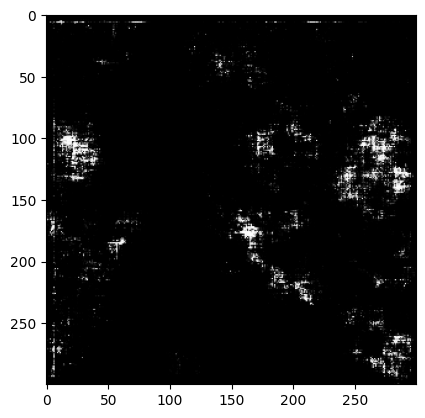

In [ ]:
result_image_rgb = cv2.cvtColor(  (result_image*255).astype(np.uint8) , cv2.COLOR_GRAY2BGR)
plt.imshow(result_image_rgb)
result_image_rgb.shape

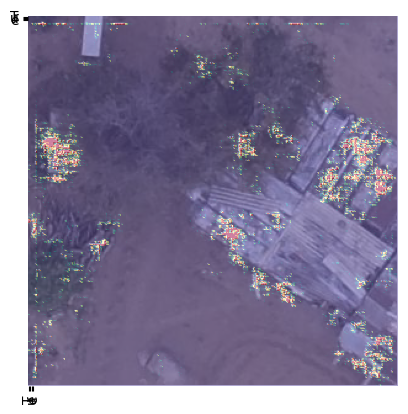

In [ ]:
# Create a Seaborn heatmap
import seaborn as sns
sns.heatmap(result_image, cmap='Spectral_r', alpha=0.5, cbar=False, xticklabels='True', yticklabels='True',vmin=0, vmax=1)
# Set the transparency level (alpha)
blended_image = cv2.addWeighted(image,1, result_image_rgb, 0.9, 1)
# Display the result using Matplotlib
plt.imshow(blended_image)
plt.show()

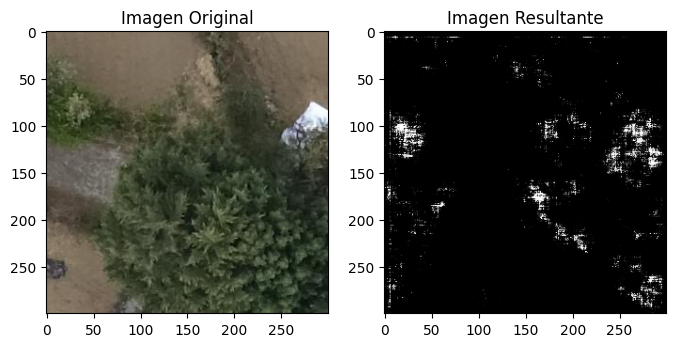

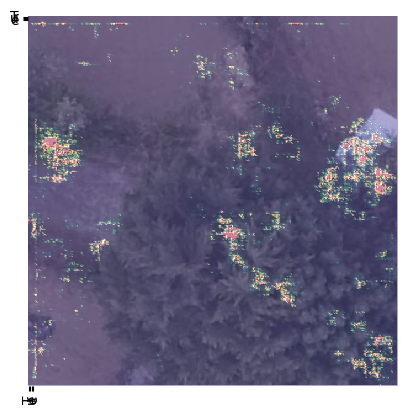

In [ ]:
# Ruta de la imagen que deseas predecir.
image_path = r"/content/drive/MyDrive/Colab_Notebooks/DJI_0120_v10_22.png"
input_image = cv2.imread(image_path)
image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

def pad_with_zeros(image, pad_size):
    padded_image = np.pad(image, [(pad_size, pad_size), (pad_size, pad_size), (0, 0)], mode='constant')
    return padded_image

def generate_tiles(image, ResNet34, classes):
    neighborhood_size = 16
    pad_size = neighborhood_size // 2
    tile_count = 0
    padded_image = pad_with_zeros(image, pad_size)
    result_image = np.zeros(image.shape[:2])

    for i in range(pad_size, padded_image.shape[0] - pad_size):
        for j in range(pad_size, padded_image.shape[1] - pad_size):
            neighborhood = padded_image[i - pad_size:i + pad_size, j - pad_size:j + pad_size]
            neighborhood = neighborhood.astype('uint8')

            # Convierte el vecindario a una imagen de Pillow
            neighborhood_image = to_pil_image(neighborhood, "RGB")

            # Aplica las transformaciones y prepara el tensor
            neighborhood_tensor = transforms(neighborhood_image)
            neighborhood_tensor = neighborhood_tensor.unsqueeze(0)
            neighborhood_tensor = neighborhood_tensor.to(device)

            with torch.no_grad():
                # Pasa el vecindario a través de la red ResNet34
                activations = ResNet34(neighborhood_tensor)
                output = ResNet34(neighborhood_tensor)
                _, predicted = torch.max(output, 1)
                predicted_class = classes[predicted.item()]
                activations_classification = activations.squeeze()

                # Incrementa el contador de tiles
                tile_count += 1
                print(f"Procesando tile {tile_count}")
                print(f'Clase predicha: {predicted_class}')

                # Imprimir el valor actual en result_image antes de la asignación
                current_value = result_image[i - pad_size, j - pad_size]
                print(f"Coordenadas: ({i - pad_size}, {j - pad_size}) - Valor antes de la asignación: {current_value}")

                output_value = activations_classification[1].item()
                print(activations_classification)

                result_image[i - pad_size, j - pad_size] = output_value
                # Imprimir el valor después de la asignación
                current_value_after_assignment = result_image[i - pad_size, j - pad_size]
                print(f"Coordenadas: ({i - pad_size}, {j - pad_size}) - Valor después de la asignación: {current_value_after_assignment}")
                print("----------------------------------------------")

    print(f"Se obtuvieron {tile_count} tiles de la imagen.")
    return result_image

    result_image = generate_tiles(image,ResNet34,classes)

    # Imprimir la imagen original
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Imagen Original')

# Imprimir la imagen resultante
plt.subplot(1, 2, 2)
plt.imshow(result_image,cmap='gray')  # Puedes ajustar el mapa de colores según sea necesario
plt.title('Imagen Resultante')

plt.show()


result_image_rgb = cv2.cvtColor(  (result_image*255).astype(np.uint8) , cv2.COLOR_GRAY2BGR)
plt.imshow(result_image_rgb)
result_image_rgb.shape


# Create a Seaborn heatmap
import seaborn as sns
sns.heatmap(result_image, cmap='Spectral_r', alpha=0.5, cbar=False, xticklabels='True', yticklabels='True',vmin=0, vmax=1)
# Set the transparency level (alpha)
blended_image = cv2.addWeighted(image,1, result_image_rgb, 0.9, 1)
# Display the result using Matplotlib
plt.imshow(blended_image)
plt.show()